## Importing Libraries

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import pyqg
from pyqg import diagnostic_tools as tools

import pyfftw


# Defining model parameters

In [2]:
year = 24*60*60*360.
day = 24*60*60.
hr = 60*60.

base_kwargs = dict(tmax=10*year, dt=1*hr, twrite=10000, tavestart=0, taveint=1*day)


bnn = { "beta": 1.5e-11, #[m^-1 s^-1]
       "delta": 0.25,
       "rek": 5.78e-7, #[s^-1]
       "rd": 15e3, # [m]
}



case2 = { "beta": 5e-12,
            "delta": 0.05,
            "rek": 3.5e-8,
            "rd": 15e3,
}

case3 = { "beta": 5e-12,
            "delta": 0.05,
            "rek": 3.5e-8,
            "rd": 20e3,
}
case4 = { "beta": 1e-11,
       "delta": 0.1,
       "rek": 7e-8, #[s^-1]
       "rd": 15e3,
}

# Utils

## Calculate the PDF

In [3]:
import numpy as np
from sklearn.neighbors import KernelDensity

def PDF_kdensity(x, xmin=None, xmax=None, Nbins=100):
    """
    x is 1D numpy array with data
    How to use:
        first apply without arguments
        Then adjust xmin, xmax, Nbins
    """    
    N = x.shape[0]

    mean = x.mean()
    sigma = x.std()
    
    if xmin is None:
        xmin = max(np.min(x), mean-6*sigma)
    if xmax is None:
        xmax = min(np.max(x), mean+6*sigma)

    bins = np.linspace(xmin, xmax, Nbins)

    

    # bandwidth = (xmax - xmin) / Nbins

    # reshape data for sklearn
    x_reshaped = x.reshape(-1, 1)
    # Check for nan and inf
    x_reshaped = x_reshaped[np.isfinite(x_reshaped)]

    kde = gaussian_kde(x_reshaped, bw_method='scott')
    pdf = kde.evaluate(bins)
    
    # fit the Kernel Density model on the data
    # kde = KernelDensity(bandwidth=bandwidth).fit(x_reshaped)
    
    # generate Nbins points evenly spaced from xmin to xmax and evaluate the density there
    # points = np.linspace(xmin, xmax, Nbins).reshape(-1, 1)
    # log_density = kde.score_samples(points)

    # convert log density to normal density
    # density = np.exp(log_density)

    return bins, pdf

from scipy.stats import gaussian_kde

def PDF_var(ds, var, lev):
        # ds_ = ds.isel(lev=lev, time=slice(-360*40, None))
        ds_ = ds.isel(lev=lev)
        if var == 'KE':
            values = KE(ds_)
        elif var == 'Ens':
            values = Ens(ds_)
        else:
            values = ds_[var]
        values = values.values.ravel()

        xmin = 0 if var in ['KE', 'Ens'] else None
        if var=='Ens' and lev==0:
            xmax = 1e-10
        elif var=='Ens' and lev==1:
            xmax = 1.5e-12
        elif var=='KE' and lev==0:
            xmax = 1.5e-2
        elif var=='KE' and lev==1:
            xmax = 5e-4
        else:
            xmax = None

        points, density = PDF_kdensity(values, xmin=xmin, xmax=xmax)
        return xr.DataArray(density, dims=f'{var}_{lev}', coords=[points])

def PDF_var_for_ross_data(ds, var, lev):
        # ds_ = ds.isel(lev=lev, time=slice(-30,None)).mean('run')
        ds_ = ds.isel(lev=lev, time=slice(-50,None)).stack(new_dim=['time', 'run'])
        if var == 'KE':
            values = KE(ds_)
        elif var == 'Ens':
            values = Ens(ds_)
        else:
            values = ds_[var]
        values = values.values.ravel()

        xmin = 0 if var in ['KE', 'Ens'] else None
        if var=='Ens' and lev==0:
            xmax = 1e-10
        elif var=='Ens' and lev==1:
            xmax = 1.5e-12
        elif var=='KE' and lev==0:
            xmax = 1.5e-2
        elif var=='KE' and lev==1:
            xmax = 5e-4
        else:
            xmax = None

        points, density = PDF_kdensity(values, xmin=xmin, xmax=xmax)
        return xr.DataArray(density, dims=f'{var}_{lev}', coords=[points])

## Spectrum

In [4]:
import numpy as np
import xarray as xr
import pyqg

coord = lambda x, name: xr.DataArray(x, attrs={'long_name': name})

class spectrum():
    def __init__(self, type='power', averaging=False, truncate=False, time=slice(-5,-1)):
        '''
        Init type of transform here
        Usage to compute power spectrum:
        spectrum()(q)
        '''
        self.type = type
        self.averaging = averaging
        self.truncate = truncate
        self.time = time

    def test(self, sp, *x):
        def sel(_x):
            __x = _x.isel(time=self.time)
            return __x - __x.mean(dim=('x','y'))

        k = sp.k; dk = k[1] - k[0]
        Esp = sp.sum() * dk
        if self.type == 'power':
            E = sel(x[0])**2
        elif self.type == 'energy':
            E = 0.5*sel(x[0])**2
        elif self.type == 'cospectrum':
            E = sel(x[0]) * sel(x[1])
        elif self.type == 'cross_layer':
            _x = sel(x[0])
            E = _x[:,:,0] * _x[:,:,1]

        E = E.mean(dim=('run','time','x','y'))
        try:
            E = E.sum(dim='lev')
        except:
            pass

        rel_error = float(np.abs((Esp-E)/E))
        #print(f'Relative error in spectral sum for {self.type}: {rel_error}')

    def fft2d(self, _xarray):
        M = _xarray.shape[-1] * _xarray.shape[-2]
        x = _xarray.isel(time=self.time).values.astype('float64')
        return np.fft.rfftn(x, axes=(-2,-1)) / M

    def isotropize(self, af2, *x, name, description, units):
        m = pyqg.QGModel(nx=len(x[0].x), log_level=0)
        if self.type != 'cross_layer':
            sp_list = []
            for z in [0,1]:
                k, sp = calc_ispec(m, af2[z,:,:], averaging=self.averaging, truncate=self.truncate)
                sp_list.append(sp) # as power spectral density

            sp = xr.DataArray(np.stack(sp_list, axis=0), dims=['lev', 'k'], coords=[m.to_dataset().lev, coord(k, 'isotropic wavenumber, $m^{-1}$')],attrs={'long_name': name, 'description': description, 'units': units})
        elif self.type == 'cross_layer':
            k, sp = calc_ispec(m, af2[:,:], averaging=self.averaging, 
                truncate=self.truncate)
            
            sp = xr.DataArray(sp, dims=['k'], 
                coords=[coord(k, 'isotropic wavenumber, $m^{-1}$')],
                attrs={'long_name': name, 'description': description, 'units': units})
        return sp
    
    def __call__(self, *_x, name='', description='', units=''):
        '''
        *x - list of xarray tensors,
        nrun x ntime x nlev x Ny x Nx
        '''
        x = []
        for xx in _x:
            if 'run' not in xx.dims:
                xx = xx.expand_dims('run')
            if 'time' not in xx.dims:
                xx = xx.expand_dims('time')
                self.time=slice(0,1)
            x.append(xx)

        if self.type == 'power':
            af2 = np.abs(self.fft2d(x[0]))**2
        elif self.type == 'energy':
            af2 = np.abs(self.fft2d(x[0]))**2 / 2
        elif self.type == 'cospectrum':
            af2 = np.real(np.conj(self.fft2d(x[0])) * self.fft2d(x[1]))
        elif self.type == 'cross_layer':
            xf = self.fft2d(x[0])
            af2 = np.real(np.conj(xf[:,:,0]) * xf[:,:,1])
        
        af2 = af2.mean(axis=(0,1))

        sp = self.isotropize(af2, *x, name=name, description=description, units=units)

        #self.test(sp, *x)

        return sp

def calc_ispec(model, _var_dens, averaging = True, truncate=True, nd_wavenumber=False, nfactor = 1):
    """Compute isotropic spectrum `phr` from 2D spectrum of variable signal2d.

    Parameters
    ----------
    model : pyqg.Model instance
        The model object from which `var_dens` originates
    
    var_dens : squared modulus of fourier coefficients like this:
        np.abs(signal2d_fft)**2/m.M**2

    averaging: If True, spectral density is estimated with averaging over circles,
        otherwise summation is used and Parseval identity holds

    truncate: If True, maximum wavenumber corresponds to inner circle in Fourier space,
        otherwise - outer circle
    
    nd_wavenumber: If True, wavenumber is nondimensional: 
        minimum wavenumber is 1 and corresponds to domain length/width,
        otherwise - wavenumber is dimensional [m^-1]

    nfactor: width of the bin in sqrt(dk^2+dl^2) units

    Returns
    -------
    kr : array
        isotropic wavenumber
    phr : array
        isotropic spectrum

    Normalization:
    signal2d.var() = phr.sum() * (kr[1] - kr[0])
    """

    # account for complex conjugate
    var_dens = np.copy(_var_dens)
    var_dens[...,0] /= 2
    var_dens[...,-1] /= 2

    ll_max = np.abs(model.ll).max()
    kk_max = np.abs(model.kk).max()

    if truncate:
        kmax = np.minimum(ll_max, kk_max)
    else:
        kmax = np.sqrt(ll_max**2 + kk_max**2)
    
    kmin = np.minimum(model.dk, model.dl)

    dkr = np.sqrt(model.dk**2 + model.dl**2) * nfactor

    # left border of bins
    kr = np.arange(kmin, kmax-dkr, dkr)
    
    phr = np.zeros(kr.size)

    for i in range(kr.size):
        if averaging:
            fkr =  (model.wv>=kr[i]) & (model.wv<=kr[i]+dkr)    
            if fkr.sum() == 0:
                phr[i] = 0.
            else:
                phr[i] = var_dens[fkr].mean() * (kr[i]+dkr/2) * np.pi / (model.dk * model.dl)
        else:
            fkr =  (model.wv>=kr[i]) & (model.wv<kr[i]+dkr)
            phr[i] = var_dens[fkr].sum() / dkr
        
        phr[i] *= 2
    
    # convert left border of the bin to center
    kr = kr + dkr/2

    # convert to non-dimensional wavenumber 
    # preserving integral over spectrum
    if nd_wavenumber:
        kr = kr / kmin
        phr = phr * kmin

    return kr, phr


import xarray as xr
def ave_lev(arr: xr.DataArray, delta):
    '''
    Average over depth xarray
    delta = H1/H2
    H = H1+H2
    Weights are:
    Hi[0] = H1/H = H1/(H1+H2)=H1/H2/(H1/H2+1)=delta/(1+delta)
    Hi[1] = H2/H = H2/(H1+H2)=1/(1+delta)
    '''
    if 'lev' in arr.dims:
        Hi = xr.DataArray([delta/(1+delta), 1/(1+delta)], dims=['lev'])
        out  = (arr*Hi).sum(dim='lev')
        out.attrs = arr.attrs
        return out
    else:
        return arr

def KE(ds):
        return (ds.u**2 + ds.v**2) * 0.5


def Ens(ds):
        return 0.5 * (relative_vorticity(ds))**2

def KE_time(ds):
        delta=0.1
        # return ave_lev(KE(ds), delta=delta).mean(('run', 'x', 'y'))
        return ave_lev(KE(ds), delta=delta).mean(( 'x', 'y'))
    

## Kintic Energy

# Defining differnet models

In [ ]:
base_kwargs['tmax'] = 0.01*year
sims = {}
sims['case2'] = {
    'label': 'Case2',
    'cnn_path':'results/Case2/BestModelBasedOnTestLoss.pt',
    'bnn_path':'results/BNN/BestModelBasedOnTestLoss.pt',
    'tl_path':'results/bnn_case2_10p/final_model_after_training.pt',
    'shallow_path':'results/shallow_1HL_Case2/BestModelBasedOnTestLoss.pt',

    'cnn_stat_path': 'results/Case2/training_mean_std.txt',
    'bnn_stat_path': 'results/BNN/training_mean_std.txt',
    'tl_stat_path': 'results/bnn_case2_10p/training_mean_std.txt',
    'shallow_stat_path': 'results/shallow_Case2/training_mean_std.txt',

    'case': case2,
}
sims['case3'] = {
    'label': 'Case3',
    'cnn_path':'results/Case3/BestModelBasedOnTestLoss.pt',
    'bnn_path':'results/BNN/BestModelBasedOnTestLoss.pt',
    'tl_path':'results/bnn_case3_10p/final_model_after_training.pt',
    'shallow_path':'results/shallow_1HL_Case3/BestModelBasedOnTestLoss.pt',

    'cnn_stat_path': 'results/Case3/training_mean_std.txt',
    'bnn_stat_path': 'results/BNN/training_mean_std.txt',
    'tl_stat_path': 'results/bnn_case3_10p/training_mean_std.txt',
    'shallow_stat_path': 'results/shallow_Case3/training_mean_std.txt',

    'case': case3,
}
sims['case4'] = {
    'label': 'Case4',
    'cnn_path':'results/Case4/BestModelBasedOnTestLoss.pt',
    'bnn_path':'results/BNN/BestModelBasedOnTestLoss.pt',
    'tl_path':'results/bnn_case4_10p/final_model_after_training.pt',
    'shallow_path':'results/shallow_1HL_Case4/BestModelBasedOnTestLoss.pt',

    'cnn_stat_path': 'results/Case4/training_mean_std.txt',
    'bnn_stat_path': 'results/BNN/training_mean_std.txt',
    'tl_stat_path': 'results/bnn_case4_10p/training_mean_std.txt',
    'shallow_stat_path': 'results/shallow_Case4/training_mean_std.txt',

    'case': case4,
}

for key, value in sims.items():
    label = value['label']
    cnn_path = value['cnn_path']
    bnn_path = value['bnn_path']
    tl_path = value['tl_path']
    shallow_path = value['shallow_path']
    cnn_stat_path = value['cnn_stat_path']
    bnn_stat_path = value['bnn_stat_path']
    tl_stat_path = value['tl_stat_path']
    shallow_stat_path = value['shallow_stat_path']
    case = value['case']
    
    # lores = run_parameterized_model(model=None, case={'nx':64, **case}, base_kwargs=base_kwargs, sampling_freq=24*60*60.)
    # lores.to_netcdf(f'{label}_lores.nc')
    # print("lores done")

    # hires = run_parameterized_model(model=None, case={'nx':128, **case}, base_kwargs=base_kwargs, sampling_freq=24*60*60.)
    # hires.to_netcdf(f'{label}_hires.nc')
    # print("hires done")

    cnn_param = CNNparametrization('deep', cnn_path, cnn_stat_path)
    print(cnn_param)
    cnn = run_parameterized_model(model=cnn_param, case={'nx':64, **case}, base_kwargs=base_kwargs, sampling_freq=24*60*60.)
    cnn.to_netcdf(f'{label}_cnn.nc')
    print("cnn done")

    bnn_param = CNNparametrization('deep', bnn_path, bnn_stat_path)
    bnn = run_parameterized_model(model=bnn_param, case={'nx':64, **case}, base_kwargs=base_kwargs, sampling_freq=24*60*60.)
    bnn.to_netcdf(f'{label}_bnn.nc')
    print("bnn done")

    tl_param = CNNparametrization('deep', tl_path, tl_stat_path)
    tl = run_parameterized_model(model=tl_param, case={'nx':64, **case}, base_kwargs=base_kwargs, sampling_freq=24*60*60.)
    tl.to_netcdf(f'{label}_tl.nc')
    print("tl done")

    shallow_param = CNNparametrization('shallow', shallow_path, shallow_stat_path)
    shallow = run_parameterized_model(model=shallow_param, case={'nx':64, **case}, base_kwargs=base_kwargs, sampling_freq=24*60*60.)
    shallow.to_netcdf(f'{label}_shallow.nc')
    print("shallow done")


In [ ]:

bnn_lowres = pyqg.QGModel(nx = 64, **base_kwargs, **bnn)
case2_lowres = pyqg.QGModel(nx = 64, **base_kwargs, **case2)
case3_lowres = pyqg.QGModel(nx = 64, **base_kwargs, **case3)
case4_lowres = pyqg.QGModel(nx = 64, **base_kwargs, **case4)

bnn_highres = pyqg.QGModel(nx = 256, **base_kwargs, **bnn)
case2_highres = pyqg.QGModel(nx = 256, **base_kwargs, **case2)
case3_highres = pyqg.QGModel(nx = 256, **base_kwargs, **case3)
case4_highres = pyqg.QGModel(nx = 256, **base_kwargs, **case4)


# Utils for long time simulation

In [4]:
import xarray as xr
import numpy as np
import pyqg

def drop_vars(ds):
    '''
    Drop complex variables 
    and convert to float32
    '''
    for key,var in ds.variables.items():
        if var.dtype == np.float64:
            ds[key] = var.astype(np.float32)
        elif var.dtype == np.complex128:
            ds = ds.drop_vars(key)
    for key in ['dqdt', 'ufull', 'vfull']:
        if key in ds.keys():
            ds = ds.drop_vars([key])
    if 'p' in ds.keys():
        ds = ds.rename({'p': 'psi'}) # Change for conventional name
    
    if ds['time'].attrs['units'] != 'days':
        ds['time'] = ds.time.values / 86400
        ds['time'].attrs['units'] = 'days'
    
    return ds

def concat_in_time(datasets):
    '''
    Concatenation of snapshots in time:
    - Concatenate everything
    - Store averaged statistics
    - Discard complex vars
    - Reduce precision
    '''
    from time import time
    # Concatenate datasets along the time dimension
    tt = time()
    ds = xr.concat(datasets, dim='time')

    # Spectral statistics are taken from the last 
    # snapshot because it is time-averaged
    for key in datasets[-1].keys():
        if 'k' in datasets[-1][key].dims:
            ds[key] = datasets[-1][key].isel(time=-1)
        
    ds = drop_vars(ds)

    return ds

def run_simulation(pyqg_params, parameterization=None, sampling_freq=24*60*60.):
    '''
    pyqg_params - only str-type parameters
    parameterization - pyqg parameterization class
    q_init - initial conditiona for PV, numpy array nlev*ny*nx
    '''
    ds = None
    pyqg_params['tmax'] = float(pyqg_params['tmax'])
    if parameterization is None:
        m = pyqg.QGModel(**pyqg_params)
    else:
        params = pyqg_params.copy()
        params['parameterization'] = parameterization
        m = pyqg.QGModel(**params, )
        
    for t in m.run_with_snapshots(tsnapstart=0, tsnapint=sampling_freq):
        
        _ds = drop_vars(m.to_dataset()).copy(deep=True)
        if ds is None:
            ds = _ds
        else:
            ds = concat_in_time([ds, _ds])
    ds.attrs['pyqg_params'] = str(pyqg_params)
    return ds

def run_parameterized_model(model, case, base_kwargs, sampling_freq=24*60*60.):
  parameterization = model # White noise in time sampling
  pyqg_params = {**case , **base_kwargs}
  ds = run_simulation(pyqg_params, parameterization, sampling_freq=sampling_freq)
  return ds


In [ ]:
# highres = run_parameterized_model(model=None, case={'nx':128, **bnn}, base_kwargs=base_kwargs, sampling_freq=24*60*60.)
base_kwargs['tmax'] = 20*year
case1_ds = run_parameterized_model(model=None, case={'nx':64, **case1}, base_kwargs=base_kwargs, sampling_freq=24*60*60.)
# case1_hires_ds = run_parameterized_model(model=None, case={'nx':128, **case1}, base_kwargs=base_kwargs, sampling_freq=24*60*60.)

# case2_ds = run_parameterized_model(model=None, case={'nx':64, **case2}, base_kwargs=base_kwargs, sampling_freq=24*60*60.)
# case3_ds = run_parameterized_model(model=None, case={'nx':64, **case3}, base_kwargs=base_kwargs, sampling_freq=24*60*60.)
# case4_ds = run_parameterized_model(model=None, case={'nx':64, **case4}, base_kwargs=base_kwargs, sampling_freq=24*60*60.)



In [5]:
def plot_spectra(m):
    m_ds = m.to_dataset().isel(time=-1)
    diag_names_enstrophy = ['ENSflux', 'ENSgenspec', 'ENSfrictionspec', 'ENSDissspec', 'ENSparamspec']
    diag_names_energy = ['APEflux', 'APEgenspec', 'KEflux', 'KEfrictionspec', 'Dissspec', 'paramspec']

    bud_labels_list = [['APE gen','APE flux','KE flux','Bottom drag','Diss.','Param.'],
                       ['ENS gen','ENS flux','Dissipation','Friction','Param.']]
    title_list = ['Spectral Energy Transfer', 'Spectral Enstrophy Transfer']
    plt.figure(figsize = [15, 5])
    for p, diag_names in enumerate([diag_names_energy, diag_names_enstrophy]):
        bud = []
        for name in diag_names:
            kr, spec = pyqg.diagnostic_tools.calc_ispec(m, getattr(m_ds, name).data.squeeze())
            bud.append(spec.copy())
        plt.subplot(1, 2, p+1)
        [plt.semilogx(kr, term, label=label) for term, label in zip(bud, bud_labels_list[p])]
        plt.semilogx(kr, -np.vstack(bud).sum(axis=0), 'k--', label = 'Resid.')
        plt.legend(loc='best')
        plt.xlabel(r'k (m$^{-1}$)'); plt.grid()
        plt.title(title_list[p])
    plt.tight_layout()

EOF ANALYSIS: 

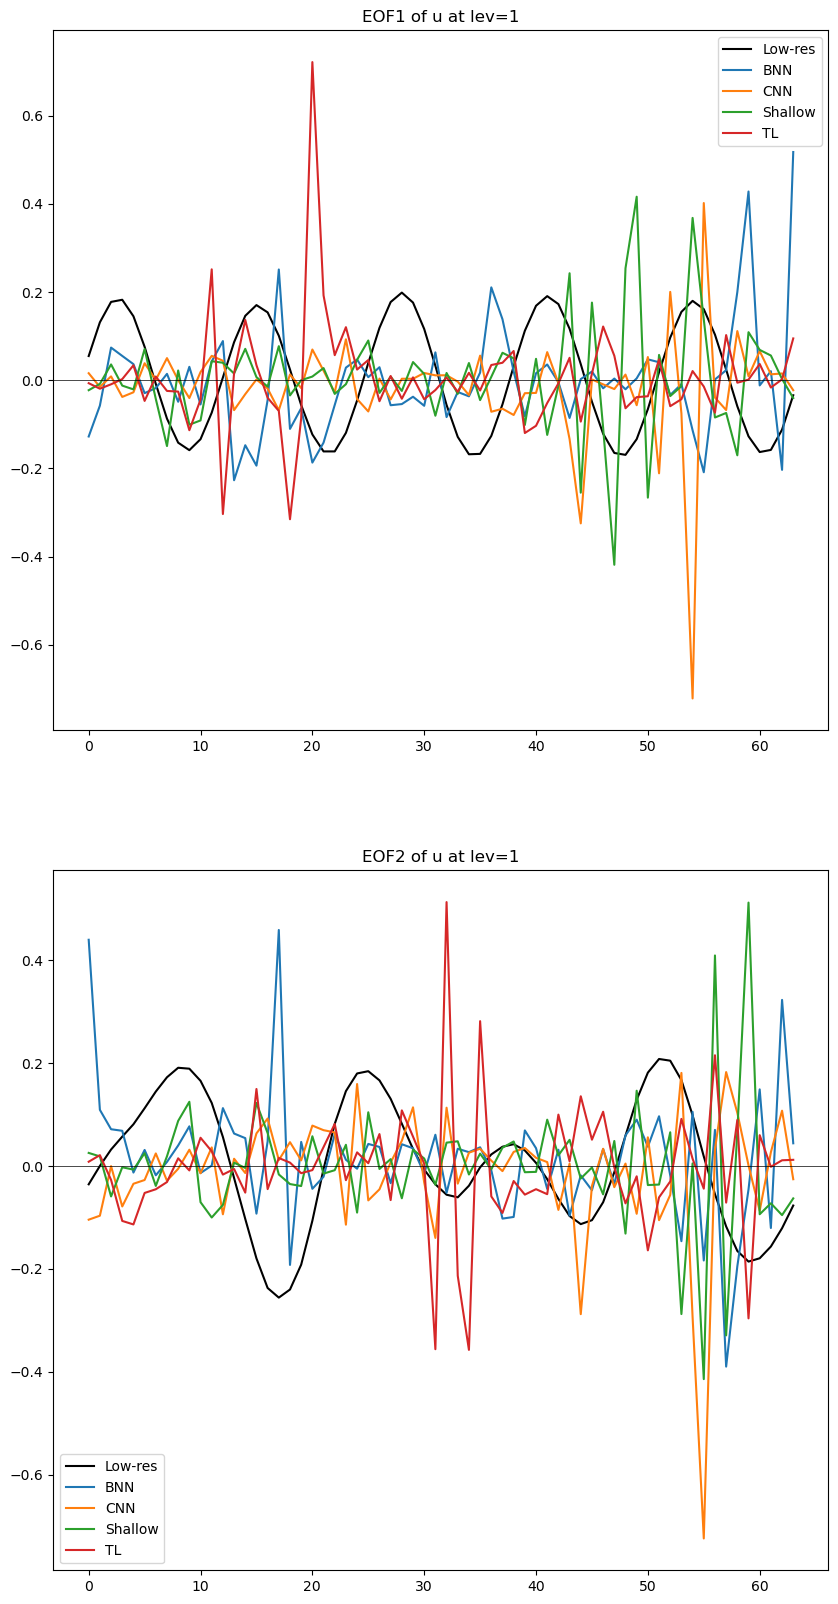

In [63]:
def EOF(ds, var, lev, n):
    X = ds[var].isel(lev=lev).mean('y').values
    cov = X.T @ X
    eigvals, eigvecs = np.linalg.eig(cov)
    return eigvecs[:, :n]

eof_case2_hires = EOF(case2_hires, 'u', 0, 2)
eof_case2_lores = EOF(case2_lores, 'q', 0, 2)
eof_case2_bnn = EOF(case2_bnn, 'u', 0, 2)
eof_case2_cnn = EOF(case2_cnn, 'u', 0, 2)
eof_case2_shallow = EOF(case2_shallow, 'u', 0, 2)
eof_case2_tl = EOF(case2_tl, 'u', 0, 2)


# The number of EOFs
num_of_EOFs = 2

plt.figure(figsize=(10, 10*num_of_EOFs)) # Adjusted the size to ensure each subplot has enough room

for i in range(num_of_EOFs):
    plt.subplot(num_of_EOFs, 1, i+1)
    # plt.plot(eof_case2_hires[:, i], label=f'High-res')
    plt.plot(eof_case2_lores[:, i], label=f'Low-res', color='black')
    plt.plot(eof_case2_bnn[:, i], label=f'BNN')
    plt.plot(eof_case2_cnn[:, i], label=f'CNN')
    plt.plot(eof_case2_shallow[:, i], label=f'Shallow')
    plt.plot(eof_case2_tl[:, i], label=f'TL')
    plt.title(f'EOF{i+1} of u at lev=1')
    plt.axhline(0, color='black', linewidth=0.5) # Draw line at y=0
    plt.legend()

plt.show()






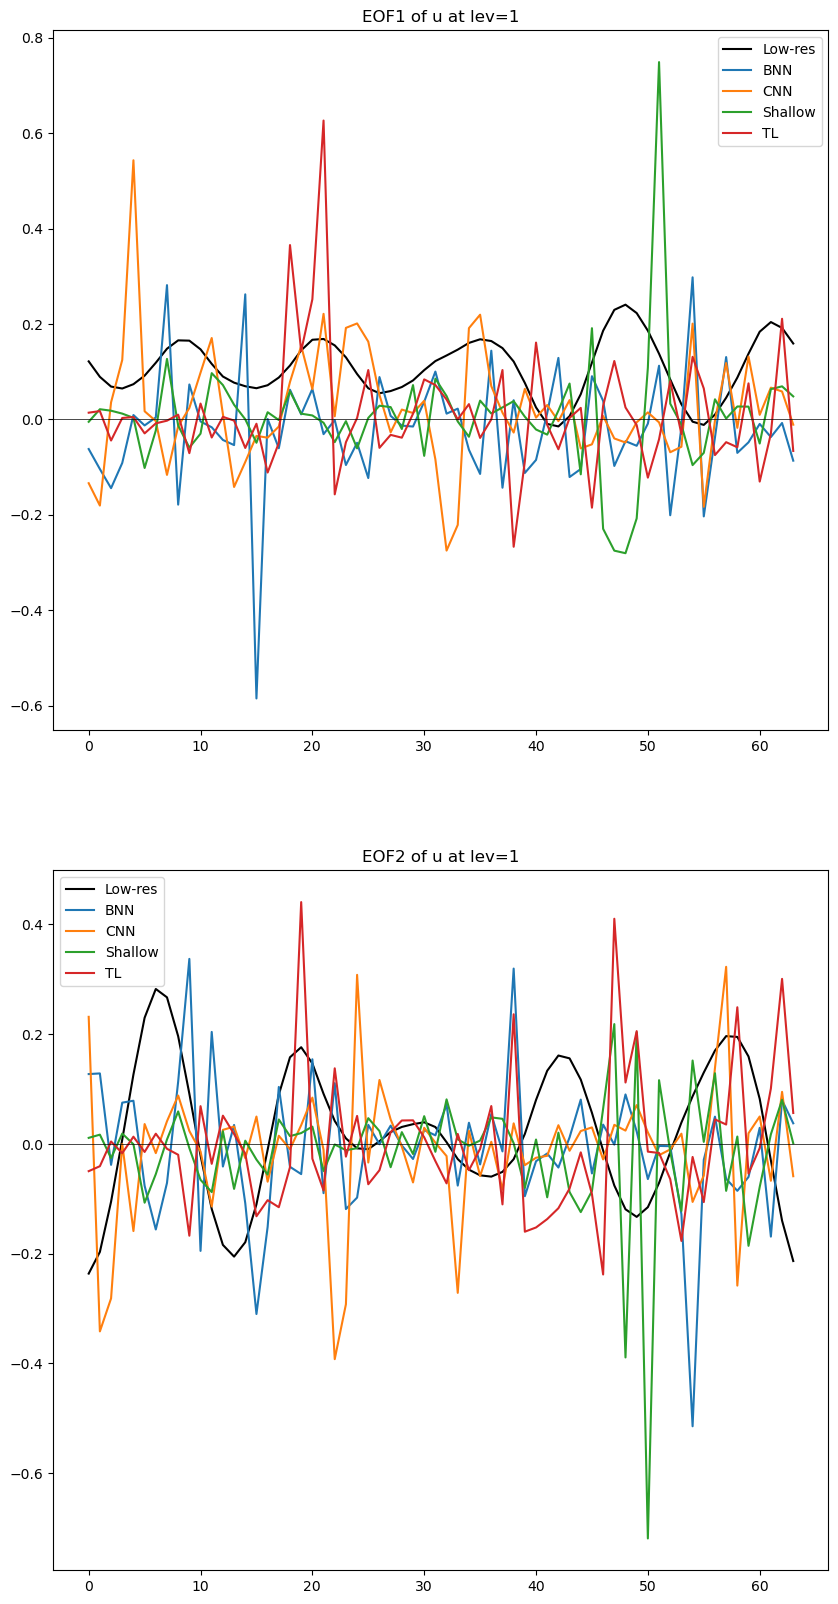

In [64]:

# EOFs for case 3
eof_case3_hires = EOF(case3_hires, 'u', 0, 2)
eof_case3_lores = EOF(case3_lores, 'q', 0, 2)
eof_case3_bnn = EOF(case3_bnn, 'u', 0, 2)
eof_case3_cnn = EOF(case3_cnn, 'u', 0, 2)
eof_case3_shallow = EOF(case3_shallow, 'u', 0, 2)
eof_case3_tl = EOF(case3_tl, 'u', 0, 2)

plt.figure(figsize=(10, 10*num_of_EOFs)) # Adjusted the size to ensure each subplot has enough room

for i in range(num_of_EOFs):
    plt.subplot(num_of_EOFs, 1, i+1)
    # plt.plot(eof_case3_hires[:, i], label=f'High-res')
    plt.plot(eof_case3_lores[:, i], label=f'Low-res', color='black')
    plt.plot(eof_case3_bnn[:, i], label=f'BNN')
    plt.plot(eof_case3_cnn[:, i], label=f'CNN')
    plt.plot(eof_case3_shallow[:, i], label=f'Shallow')
    plt.plot(eof_case3_tl[:, i], label=f'TL')
    plt.title(f'EOF{i+1} of u at lev=1')
    plt.axhline(0, color='black', linewidth=0.5) # Draw line at y=0
    plt.legend()

plt.show()


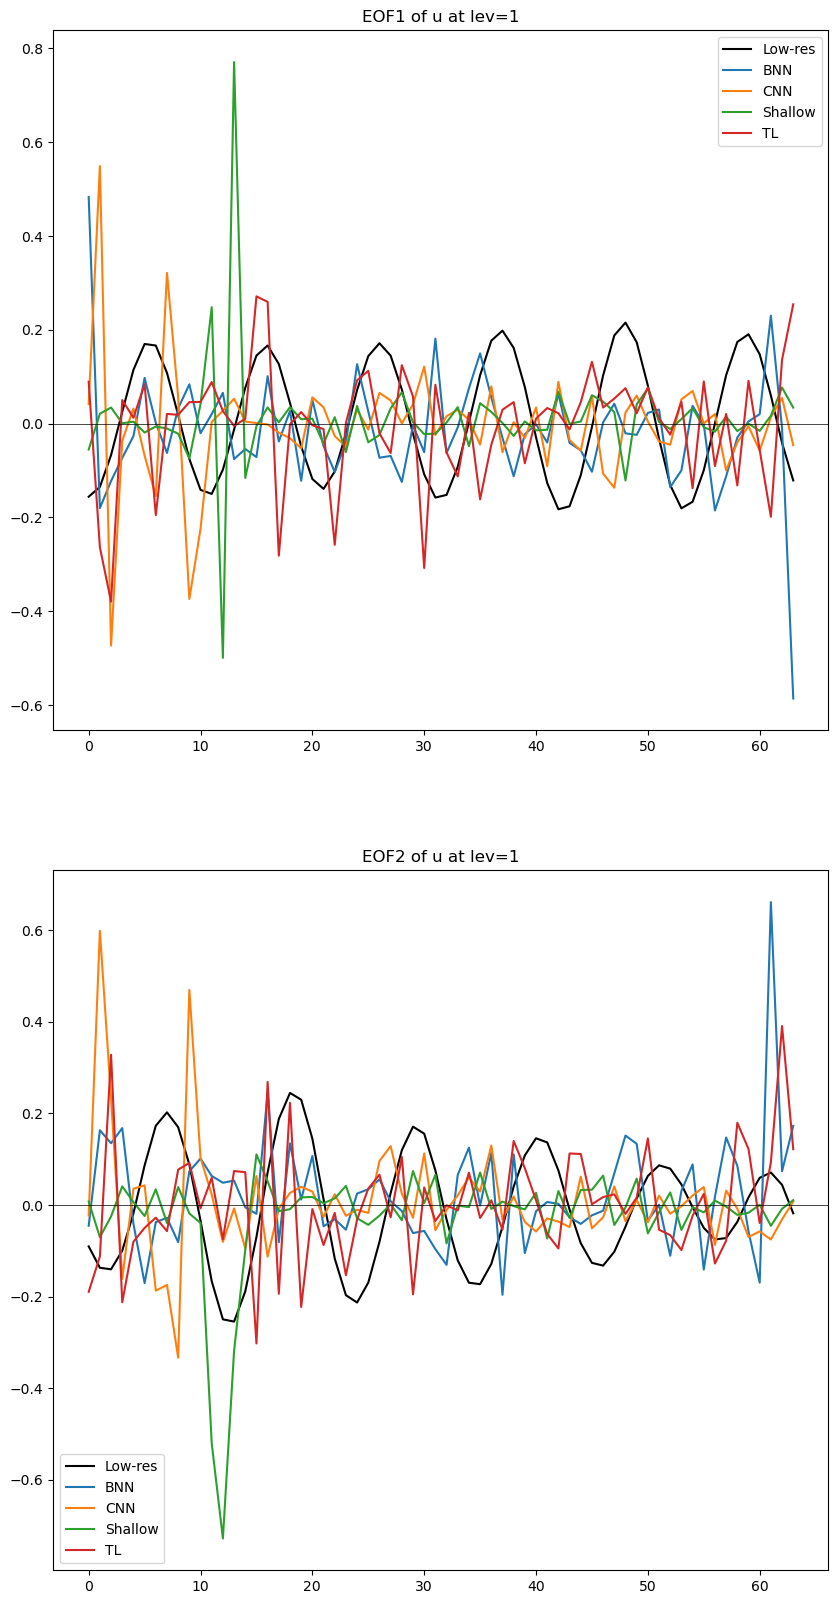

In [65]:

# EOFs for case 4

eof_case4_hires = EOF(case4_hires, 'u', 0, 2)
eof_case4_lores = EOF(case4_lores, 'q', 0, 2)
eof_case4_bnn = EOF(case4_bnn, 'u', 0, 2)
eof_case4_cnn = EOF(case4_cnn, 'u', 0, 2)
eof_case4_shallow = EOF(case4_shallow, 'u', 0, 2)
eof_case4_tl = EOF(case4_tl, 'u', 0, 2)

plt.figure(figsize=(10, 10*num_of_EOFs)) # Adjusted the size to ensure each subplot has enough room

for i in range(num_of_EOFs):
    plt.subplot(num_of_EOFs, 1, i+1)
    # plt.plot(eof_case4_hires[:, i], label=f'High-res')
    plt.plot(eof_case4_lores[:, i], label=f'Low-res', color='black')
    plt.plot(eof_case4_bnn[:, i], label=f'BNN')
    plt.plot(eof_case4_cnn[:, i], label=f'CNN')
    plt.plot(eof_case4_shallow[:, i], label=f'Shallow')
    plt.plot(eof_case4_tl[:, i], label=f'TL')
    plt.title(f'EOF{i+1} of u at lev=1')
    plt.axhline(0, color='black', linewidth=0.5) # Draw line at y=0
    plt.legend()

plt.show()

In [4]:
import xarray as xr
year = 24*60*60*360.

expected_vars = [
    'q', 
    'u', 
    'v', 
    # 'ufull', 
    # 'vfull', 
    'p',
    # 'dqdt',
    # 'qh', 
    # 'uh', 
    # 'vh', 
    # 'ph', 
    # 'Ubg', 
    'Qy',
    # 'dqhdt',
]

expected_diags = [
    'EKE', 
    'entspec', 
    'APEflux', 
    'APEflux_div', 
    'KEflux', 
    'KEflux_div', 
    'APEgen',
    'APEgenspec',
    'Ensspec',
    'KEspec',
    'EKEdiss',
    'KEspec_modal',
    'PEspec_modal',
    'APEspec',
    'ENSflux',
    'ENSgenspec',
    'paramspec',
    'paramspec_APEflux',
    'paramspec_KEflux',
    'Dissspec',
    'KEfrictionspec',
    'ENSDissspec',
    'ENSfrictionspec',
    'ENSparamspec',
]

expected_attrs = [
    'L',
    'W',
    'dt',
    'filterfac',
    'nk',
    'nl',
    'ntd',
    'nx',
    'ny',
    'nz',
    'rek',
    'taveint',
    'tavestart',
    'tc',
    'tmax',
    'twrite',
]

expected_coords = [
    'time',
    'lev',
    'x',
    'y',
    'l',
    'k',
]

def test_xarray(all_models):
    '''Run with snapshots and test contents of xarray.dataset'''
    m=all_models
    tsnapint=year/4
    datasets = []
    timevals = []

    for snapshot in m.run_with_snapshots(tsnapstart=m.t, tsnapint=tsnapint):
        ds = m.to_dataset()
        assert type(ds) == xr.Dataset

        datasets.append(ds)
        timevals.append(m.t)

        if snapshot < tsnapint:

            for v in expected_vars:
                assert v in ds

            for a in expected_attrs:
                assert f"pyqg:{a}" in ds.attrs

            for c in expected_coords:
                assert c in ds.coords

        if snapshot > tsnapint:

            for v in list(ds.keys()): 
                assert v in expected_vars + expected_diags

            for v in expected_diags:
                if v in ds:
                    assert 'time' in ds[v].coords

            for a in expected_attrs:
                assert f"pyqg:{a}" in ds.attrs

            for c in expected_coords:
                assert c in ds.coords

    concatenated = xr.concat(datasets, dim='time')

    assert np.allclose(concatenated.coords['time'], timevals)

In [22]:
import torch
import torch.nn as nn
from pyqg import Parameterization
import json 

class CNNparametrization(Parameterization):
    def __init__(self, model_type, model_path, stat_path=None):
        super().__init__()
        self.model = self.init_model(model_type, model_path)
        
        # Load .txt
        with open(stat_path) as json_file:
            data = json.load(json_file)
            self.input_mean = torch.tensor(data['input_mean_train']).reshape(4, 1, 1)
            self.input_std = torch.tensor(data['input_std_train']).reshape(4, 1, 1)
            self.output_mean = torch.tensor(data['output_mean_train']).reshape(2, 1, 1)
            self.output_std = torch.tensor(data['output_std_train']).reshape(2, 1, 1)


    def __call__(self, m):
        # Here you will need to transform your model `m` into the appropriate input tensor for the CNN
        # As I don't know the exact structure of your model and the expected input for the CNN, 
        # I'm using a placeholder function `prepare_input(m)`. You will need to implement this function.
        input_tensor = self.prepare_input(m) 
        # Then you can use the evaluate_model function to get the output of the CNN
        output = self.evaluate_model(self.model, input_tensor)
        return output
    
    def prepare_input(self, m):
        # get the model variables 'u' and 'v'
        u = m.u
        v = m.v
        # Ensure that 'u' and 'v' are numpy arrays
        if not isinstance(u, np.ndarray):
            u = np.array(u)
        if not isinstance(v, np.ndarray):
            v = np.array(v)
        # concatenate 'u' and 'v' across the first axis
        combined = np.concatenate((u, v), axis=0)
        # Convert the combined array to a torch tensor
        input_tensor = torch.from_numpy(combined)
        # Ensure the tensor is of the right type
        input_tensor = input_tensor.float()
        return input_tensor

    def evaluate_model(self, model, input_tensor):
        # Set device to GPU if available, otherwise use CPU
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        # Move the input tensor to the specified device
        input_tensor = input_tensor.to(device=device)

        # Normalize the input tensor    
        
        input_tensor = (input_tensor - self.input_mean.to(device)) / self.input_std.to(device)
        
        # Pass the input tensor through the model
        output, _ = model(input_tensor)
        
        # Denormalize the output tensor
        output = output * self.output_std.to(device) + self.output_mean.to(device)
        
        # Move the output tensor back to the CPU and numpy
        output = output.cpu().detach().numpy()
        
        # Ensure 'output' is of type float64
        output = output.astype(np.float64)

        return output

    def init_model(self, model_type, model_path):
        # Define the ConvNeuralNet classes for each model type
# -------------------------------------------------- Deep ------------------------------------------------------------------------------------------------------------------------
        if model_type == 'deep':
            class ConvNeuralNet(nn.Module):
                
                # Determine what layers and their order in CNN object
                def __init__(self, num_classes):

                        super(ConvNeuralNet, self).__init__()

                        # Input Layer
                        self.conv_layer1 = nn.Conv2d(in_channels=4, out_channels=64, kernel_size=5, padding="same")
                        
                        # Hidden layers
                        self.conv_layer2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, padding="same")
                        self.conv_layer3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, padding="same")
                        self.conv_layer4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, padding="same")
                        self.conv_layer5 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, padding="same")
                        self.conv_layer6 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, padding="same")
                        self.conv_layer7 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, padding="same")
                        # self.conv_layer8 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, padding="same")
                        # self.conv_layer9 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, padding="same")
                        # self.conv_layer10 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, padding="same")
                        
                        # Output layer
                        self.conv_layer11 = nn.Conv2d(in_channels=64, out_channels=2, kernel_size=5, padding="same")
                        
                        # Activation function
                        self.relu1 = nn.ReLU()
                        
                def forward(self, x):

                        out1_before = self.conv_layer1(x) # Layer1 (Input Layer)
                        out1_after = self.relu1(out1_before) # Layer1 (Input Layer)    
                        
                        ## Hidden Layers
                        out2_before = self.conv_layer2(out1_after) #Layer2
                        out2_after = self.relu1(out2_before) #Layer2
                    
                        out3_before = self.conv_layer3(out2_after) #Layer3
                        out3_after = self.relu1(out3_before) #Layer3

                        out4_before = self.conv_layer4(out3_after) #Layer4
                        out4_after = self.relu1(out4_before) #Layer4

                        out5_before = self.conv_layer5(out4_after) #Layer5
                        out5_after = self.relu1(out5_before) #Layer5

                        out6_before = self.conv_layer6(out5_after) #Layer6
                        out6_after = self.relu1(out6_before) #Layer6

                        out7_before = self.conv_layer7(out6_after) #Layer7
                        out7_after = self.relu1(out7_before) #Layer7

                        # out8 = self.relu1(self.conv_layer8(out7)) #Layer8

                        # out9 = self.relu1(self.conv_layer9(out8)) #Layer9

                        # out10 = self.relu1(self.conv_layer10(out9)) #Layer10
                        
                        ####  !!! Do not forget to change teh output layer when changing the number of hidden layers !!! ####

                        output = self.conv_layer11(out7_after) #Layer11 (Output Layer) 
                        mid_ouptut = {'out1_before': out1_before, 'out1_after': out1_after, 'out2_before': out2_before, 'out2_after': out2_after, 'out3_before': out3_before, 'out3_after': out3_after, 'out4_before': out4_before, 'out4_after': out4_after, 'out5_before': out5_before, 'out5_after': out5_after, 'out6_before': out6_before, 'out6_after': out6_after, 'out7_before': out7_before, 'out7_after': out7_after}
                        return output, mid_ouptut
# -------------------------------------------------- Shallow ------------------------------------------------------------------------------------------------------------------------
        elif model_type == 'shallow':
            class ConvNeuralNet(nn.Module):

                # Determine what layers and their order in CNN object
                def __init__(self, num_classes):

                        super(ConvNeuralNet, self).__init__()
                        # Input Layer
                        self.conv_layer1 = nn.Conv2d(in_channels=4, out_channels=64, kernel_size=5, padding="same")
                        
                        # Hidden layers
                        self.conv_layer2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, padding="same")
                        # self.conv_layer3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, padding="same")
                        # self.conv_layer4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, padding="same")
                        # self.conv_layer5 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, padding="same")
                        # self.conv_layer6 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, padding="same")
                        # self.conv_layer7 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, padding="same")
                        # self.conv_layer8 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, padding="same")
                        # self.conv_layer9 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, padding="same")
                        # self.conv_layer10 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, padding="same")
                        
                        # Output layer
                        self.conv_layer11 = nn.Conv2d(in_channels=64, out_channels=2, kernel_size=5, padding="same")
                        
                        # Activation function
                        self.relu1 = nn.ReLU()
                        
                def forward(self, x):

                        out1_before = self.conv_layer1(x) # Layer1 (Input Layer)
                        out1_after = self.relu1(out1_before) # Layer1 (Input Layer)    
                        
                        ## Hidden Layers
                        out2_before = self.conv_layer2(out1_after) #Layer2
                        out2_after = self.relu1(out2_before) #Layer2
                    
                        # out3_before = self.conv_layer3(out2_after) #Layer3
                        # out3_after = self.relu1(out3_before) #Layer3

                        # out4_before = self.conv_layer4(out3_after) #Layer4
                        # out4_after = self.relu1(out4_before) #Layer4

                        # out5_before = self.conv_layer5(out4_after) #Layer5
                        # out5_after = self.relu1(out5_before) #Layer5

                        # out6_before = self.conv_layer6(out5_after) #Layer6
                        # out6_after = self.relu1(out6_before) #Layer6

                        # out7_before = self.conv_layer7(out6_after) #Layer7
                        # out7_after = self.relu1(out7_before) #Layer7

                        # out8 = self.relu1(self.conv_layer8(out7)) #Layer8

                        # out9 = self.relu1(self.conv_layer9(out8)) #Layer9

                        # out10 = self.relu1(self.conv_layer10(out9)) #Layer10
                        
                        ####  !!! Do not forget to change teh output layer when changing the number of hidden layers !!! ####

                        output = self.conv_layer11(out2_after) #Layer11 (Output Layer) 
                        mid_ouptut = {'out1_before': out1_before, 'out1_after': out1_after, 'out2_before': out2_before, 'out2_after': out2_after, }
                        return output, mid_ouptut
        else:
            print('Invalid model type. Please choose from "deep" or "shallow"')

        # Set device to GPU if available, otherwise use CPU
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # Create model instance and move it to the specified device
        model = ConvNeuralNet(1).to(device=device)

        # Load the checkpoint
        checkpoint = torch.load(model_path, map_location=device)

        # Extract the model_state_dict from the checkpoint
        model_state_dict = checkpoint['model_state_dict']

        # Load the state dictionary into the model
        model.load_state_dict(model_state_dict)

        # Move the model to the specified device
        model.to(device)

        # Set the model to evaluation mode
        model.eval()

        return model

    @property
    def parameterization_type(self):
        return "q_parameterization"




In [56]:
case2_lores = xr.open_dataset('Case2_lores.nc')
case2_hires = xr.open_dataset('Case2_hires.nc')
case2_cnn = xr.open_dataset('Case2_cnn.nc')
index= 120
case2_training = xr.open_dataset(f'/media/volume/sdc/data_qg/3jet/{index}.nc')

ke_lores = KE(case2_lores)
ke_hires = KE(case2_hires)
ke_cnn = KE(case2_cnn)
ke_training = KE(case2_training)

ke_time_lores = KE_time(case2_lores)
ke_time_hires = KE_time(case2_hires)
ke_time_training = KE_time(case2_training)
ke_time_cnn = KE_time(case2_cnn)

In [8]:
# Load tar file
# Extract tar file
import xarray as xr
forcing1 = xr.open_zarr('/media/volume/sdc/ross_data/publication/jet/forcing1.zarr')
forcing2  = xr.open_zarr('/media/volume/sdc/ross_data/publication/jet/forcing2.zarr')
forcing3  = xr.open_zarr('/media/volume/sdc/ross_data/publication/jet/forcing3.zarr')
high_res  = xr.open_zarr('/media/volume/sdc/ross_data/publication/jet/high_res.zarr')
low_res = xr.open_zarr('/media/volume/sdc/ross_data/publication/jet/low_res.zarr')
cnn = xr.open_dataset('/media/volume/sdc/qg/TransferLearning-QG/case4_cnn_new.nc')
spectral_filter_cnn_40years = xr.open_dataset('/media/volume/sdc/qg/TransferLearning-QG/case4_cnn_test_with_from_fd_condition_40years.nc')
spectral_filter_cnn_20years = xr.open_dataset('/media/volume/sdc/qg/TransferLearning-QG/case4_cnn_test_with_from_fd_condition_20years.nc')
spectral_filter_cnn_10years = xr.open_dataset('/media/volume/sdc/qg/TransferLearning-QG/case4_cnn_test_with_from_fd_condition.nc')
theirs = xr.open_dataset('/media/volume/sdc/ross_data/m2lines-pyqg_parameterization_benchmarks-d2f7278/models/fcnn_q_to_Sqtot1/jet_run.nc')
case4_tl = xr.open_dataset('/media/volume/sdc/qg/TransferLearning-QG/spectral_filter_results_tl.nc')

case4_hi = xr.open_dataset('/media/volume/sdc/qg/TransferLearning-QG/case4_hires.nc')


# give_data = xr.open_dataset(f'/media/volume/sdc/data_qg/3jet/2.nc')

# ke_highres = KE(high_res.isel(lev=0).mean(('time', 'run')))
# kr_case4_highres, case4_spec_highres = calc_ispec(case4_highres, ke_highres['KEspec'])

kr_case4_highres, case4_spec_highres = calc_ispec(case4_highres, high_res['KEspec'].isel(lev=0).mean(( 'run')))
kr_case4_lowres, case4_spec_lowres = calc_ispec(case4_lowres, low_res['KEspec'].isel(lev=0).mean(( 'run')))
kr_case4_forcing1, case4_spec_forcing1 = calc_ispec(case4_lowres, forcing1['KEspec'].isel(lev=0).mean(( 'run')))
kr_case4_forcing2, case4_spec_forcing2 = calc_ispec(case4_lowres, forcing2['KEspec'].isel(lev=0).mean(( 'run')))
kr_case4_forcing3, case4_spec_forcing3 = calc_ispec(case4_lowres, forcing3['KEspec'].isel(lev=0).mean(( 'run')))
kr_case4_cnn, case4_spec_cnn = calc_ispec(case4_lowres, cnn['KEspec'].isel(lev=0))

kr_case4_spectral_filter_cnn_40years, case4_spec_spectral_filter_cnn_40years = calc_ispec(case4_lowres, spectral_filter_cnn_40years['KEspec'].isel(lev=0))
kr_case4_spectral_filter_cnn_20years, case4_spec_spectral_filter_cnn_20years = calc_ispec(case4_lowres, spectral_filter_cnn_20years['KEspec'].isel(lev=0))
kr_case4_spectral_filter_cnn_10years, case4_spec_spectral_filter_cnn_10years = calc_ispec(case4_lowres, spectral_filter_cnn_10years['KEspec'].isel(lev=0))

kr_case4_tl, case4_spec_tl = calc_ispec(case4_lowres, case4_tl['KEspec'].isel(lev=0))
kr_case4_theirs, case4_spec_theirs = calc_ispec(case4_lowres, theirs['KEspec'].isel(lev=0))

kr_case4_hi, case4_spec_hi = calc_ispec(case4_highres, case4_hi['KEspec'].isel(lev=0))







plt.figure(figsize=(15, 5), dpi=1200)
plt.rcParams.update({'font.size': 12})
plt.rc('text', usetex=True)

plt.loglog(kr_case4_highres, case4_spec_highres, label=r'HighRes $(N_x=256)$', color='black', linewidth=3)
plt.loglog(kr_case4_lowres, case4_spec_lowres, label=r'NoSGS $(N_x=64)$', color='gray', linewidth=3)
plt.loglog(kr_case4_forcing1, case4_spec_forcing1, label='FDNS (Spectral Filter)', color='red', linestyle='solid', linewidth=2)
plt.loglog(kr_case4_forcing2, case4_spec_forcing2, label='FDNS (Gaussian Filter)', color='blue', linestyle='solid', linewidth=2)
# plt.loglog(kr_case4_spectral_filter_cnn_10years, case4_spec_spectral_filter_cnn_10years, label='CNN trained on Spectral Filter (10 years)', color='red', linewidth=2, linestyle='--')
# plt.loglog(kr_case4_spectral_filter_cnn_20years, case4_spec_spectral_filter_cnn_20years, label='CNN trained on Spectral Filter (20 years)', color='red', linewidth=2, linestyle='--')
plt.loglog(kr_case4_spectral_filter_cnn_40years, case4_spec_spectral_filter_cnn_40years, label='CNN trained on Spectral Filter (40 years)', color='red', linewidth=2, linestyle='--')
plt.loglog(kr_case4_cnn, case4_spec_cnn, label='CNN trained on Gaussian Filter', color='blue', linewidth=2, linestyle='--')

plt.loglog(kr_case4_tl, case4_spec_tl, label='Transfer Learning', color='green', linewidth=2, linestyle='--')

# Plot the mean of all years
# plt.loglog(kr_case4_spectral_filter_cnn_40years, (case4_spec_spectral_filter_cnn_40years+case4_spec_spectral_filter_cnn_20years+case4_spec_spectral_filter_cnn_10years)/3, label='CNN trained on Spectral Filter (40 years)', color='red', linewidth=2, linestyle='--')
# plt.loglog(kr_case4_cnn, case4_spec_cnn, label='CNN trained on Gaussian Filter', color='blue', linewidth=2, linestyle='--')
# plt.loglog(kr_case4_theirs, case4_spec_theirs, label='FCNN trained on Spectral Filter (Ross et al.)', color='green', linewidth=2, linestyle='--')
# plt.loglog(kr_case4_hi, case4_spec_hi, label='HighRes (N_x=256)', color='green', linewidth=2, linestyle='--')
# plt.loglog(kr_case4_forcing3, case4_spec_forcing3, label='Real Space Filter', color='green', linestyle='--')

plt.ylabel(r'TKE Spectra $(m^3/s^2)$')
plt.xlabel(r'$\kappa_x (m^{-1})$')
plt.grid(True, which="both", ls="-")
plt.legend(frameon=True, fontsize=12)
plt.ylim(1e-3, 2e2)


(0.001, 200.0)

In [44]:
# Calculate the PDF of of the CNN and highres and FDNS
pdf_q0_case4_cnn = PDF_var(cnn, 'q', 0)


In [65]:
ds_stacked = high_res.isel(lev=0).stack(new_dim=['time', 'run'])
ds_stacked = ds.isel(lev=lev).stack(new_dim=['time', 'run'])



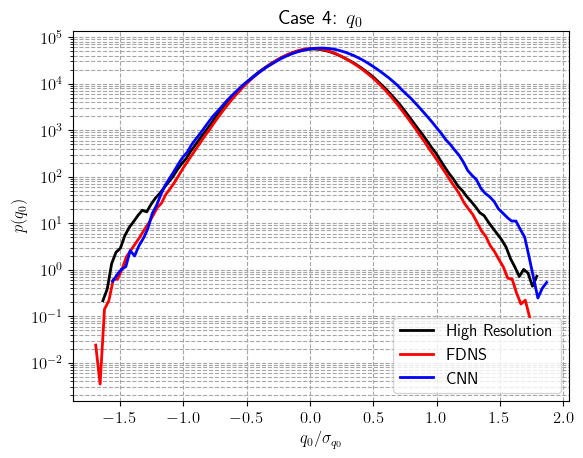

In [87]:
pdf_q0_case4_hires = PDF_var_for_ross_data(high_res, 'q', 0)
pdf_q0_case4_fdns = PDF_var_for_ross_data(forcing1, 'q', 0)
pdf_q0_spectral_filter_cnn_40years = PDF_var(spectral_filter_cnn_40years, 'q', 0)
# plt.plot(pdf_q0_case4_cnn.coords['q_0'].values/np.std(pdf_q0_case4_cnn.coords['q_0'].values), pdf_q0_case4_cnn, label='CNN', color='blue', linewidth=2)




In [91]:
pdf_q0_spectral_filter_cnn_20years = PDF_var(spectral_filter_cnn_20years, 'q', 0)

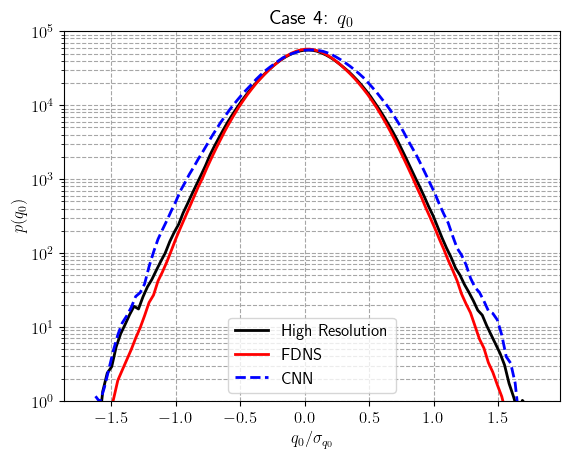

In [99]:
plt.plot(pdf_q0_case4_hires.coords['q_0'].values/np.std(pdf_q0_case4_hires.coords['q_0'].values), pdf_q0_case4_hires, label='High Resolution', color='black', linewidth=2)
plt.plot(pdf_q0_case4_fdns.coords['q_0'].values/np.std(pdf_q0_case4_fdns.coords['q_0'].values), pdf_q0_case4_fdns, label='FDNS', color='red', linewidth=2)
# plt.plot(pdf_q0_spectral_filter_cnn_40years.coords['q_0'].values/np.std(pdf_q0_spectral_filter_cnn_40years.coords['q_0'].values), pdf_q0_spectral_filter_cnn_40years, label='CNN', color='blue', linewidth=2)
plt.plot(pdf_q0_spectral_filter_cnn_20years.coords['q_0'].values/np.std(pdf_q0_spectral_filter_cnn_20years.coords['q_0'].values), pdf_q0_spectral_filter_cnn_20years, label='CNN', color='blue', linewidth=2, linestyle='--')

plt.grid(True, which="both", ls="--", color='0.65')
plt.title('Case 4: $q_0$')
plt.yscale('log')
plt.xlabel(r'$q_0/\sigma_{q_0}$')
plt.ylabel(r'$p(q_0)$')
plt.ylim(1e0, 1e5)
plt.legend()
plt.show()

In [21]:
# Load tar file
# Extract tar file
import xarray as xr
case0_forcing1 = xr.open_zarr('/media/volume/sdc/ross_data/publication/eddy/forcing1.zarr')
case0_forcing2  = xr.open_zarr('/media/volume/sdc/ross_data/publication/eddy/forcing2.zarr')
case0_forcing3  = xr.open_zarr('/media/volume/sdc/ross_data/publication/eddy/forcing3.zarr')
case0_high_res  = xr.open_zarr('/media/volume/sdc/ross_data/publication/eddy/high_res.zarr')
case0_low_res = xr.open_zarr('/media/volume/sdc/ross_data/publication/eddy/low_res.zarr')
case0_cnn = xr.open_dataset('/media/volume/sdc/qg/TransferLearning-QG/eddy_40years.nc')
case0_theirs = xr.open_dataset('/media/volume/sdc/ross_data/m2lines-pyqg_parameterization_benchmarks-d2f7278/models/fcnn_q_to_Sqtot1/eddy_run.nc')
case0_spectral_cnn = xr.open_dataset('/media/volume/sdc/qg/TransferLearning-QG/eddy_40years_spectral_filter.nc')


# give_data = xr.open_dataset(f'/media/volume/sdc/data_qg/3jet/2.nc')

# ke_highres = KE(high_res.isel(lev=0).mean(('time', 'run')))
# kr_case4_highres, case4_spec_highres = calc_ispec(case4_highres, ke_highres['KEspec'])

kr_case0_highres, case0_spec_highres = calc_ispec(bnn_highres, case0_high_res['KEspec'].isel(lev=0).mean(( 'run')))
kr_case0_lowres, case0_spec_lowres = calc_ispec(bnn_lowres, case0_low_res['KEspec'].isel(lev=0).mean(( 'run')))
kr_case0_forcing1, case0_spec_forcing1 = calc_ispec(bnn_lowres, case0_forcing1['KEspec'].isel(lev=0).mean(( 'run')))
kr_case0_forcing2, case0_spec_forcing2 = calc_ispec(bnn_lowres, case0_forcing2['KEspec'].isel(lev=0).mean(( 'run')))
kr_case0_forcing3, case0_spec_forcing3 = calc_ispec(bnn_lowres, case0_forcing3['KEspec'].isel(lev=0).mean(( 'run')))
kr_case0_cnn, case0_spec_cnn = calc_ispec(bnn_lowres, case0_cnn['KEspec'].isel(lev=0))
kr_case0_theirs, case0_spec_theirs = calc_ispec(bnn_lowres, case0_theirs['KEspec'].isel(lev=0))
kr_case0_spectral_cnn, case0_spec_spectral_cnn = calc_ispec(bnn_lowres, case0_spectral_cnn['KEspec'].isel(lev=0))


plt.figure(figsize=(15, 5), dpi=1200)
plt.rcParams.update({'font.size': 12})
plt.rc('text', usetex=True)

plt.loglog(kr_case0_highres, case0_spec_highres, label=r'HighRes $(N_x=256)$', color='black', linewidth=3)
plt.loglog(kr_case0_lowres, case0_spec_lowres, label=r'NoSGS $(N_x=64)$', color='gray', linewidth=3)
plt.loglog(kr_case0_forcing1, case0_spec_forcing1, label='FDNS (Spectral Filter)', color='red', linestyle='solid', linewidth=2)
# plt.loglog(kr_case0_forcing2, case0_spec_forcing2, label='FDNS (Gaussian Filter)', color='blue', linestyle='solid', linewidth=2)
# plt.loglog(kr_case4_spectral_filter_cnn, case4_spec_spectral_filter_cnn, label='CNN trained on Spectral Filter', color='red', linewidth=2, linestyle='--')
plt.loglog(kr_case0_theirs, case0_spec_theirs, label='FCNN trained on Spectral Filter (Ross et al.)', color='red', linewidth=2, linestyle='--')
plt.loglog(kr_case0_spectral_cnn, case0_spec_spectral_cnn, label='CNN trained on Spectral Filter (Moein)', color='orange', linewidth=2, linestyle='--')
# plt.loglog(kr_case0_cnn, case0_spec_cnn, label='CNN trained on Gaussian Filter (Moein)', color='blue', linewidth=2, linestyle='--')

# plt.loglog(kr_case4_theirs, case4_spec_theirs, label='FCNN trained on Spectral Filter (Ross et al.)', color='green', linewidth=2, linestyle='--')
# plt.loglog(kr_case4_forcing3, case4_spec_forcing3, label='Real Space Filter', color='green', linestyle='--')

plt.ylabel(r'TKE Spectra $(m^3/s^2)$')
plt.xlabel(r'$\kappa_x (m^{-1})$')
plt.grid(True, which="both", ls="-")
plt.legend(frameon=True, fontsize=12)
plt.ylim(1e-3, 2e2)


(0.001, 200.0)

In [49]:
# PDF for Case 0
# pdf_q0_case0_spectral_cnn = PDF_var(case0_spectral_cnn, 'q', 0)
pdf_q0_case0_hires = PDF_var_for_ross_data(case0_high_res, 'q', 0)
pdf_q0_case0_fdns = PDF_var_for_ross_data(case0_forcing1, 'q', 0)


In [66]:
pdf_q0_case0_spectral_cnn = PDF_var(case0_spectral_cnn, 'q', 0)

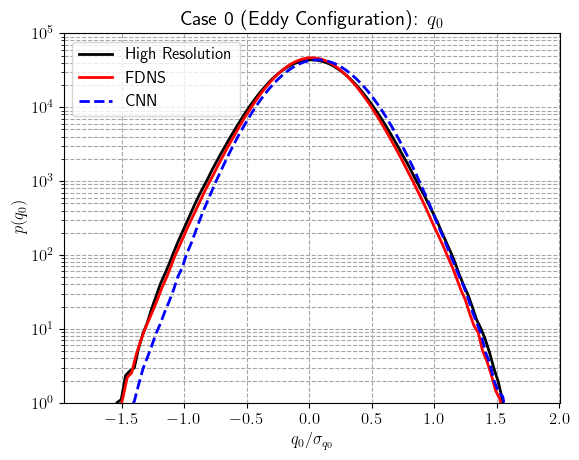

In [70]:
plt.plot(pdf_q0_case0_hires.coords['q_0'].values/np.std(pdf_q0_case0_hires.coords['q_0'].values), pdf_q0_case0_hires, label='High Resolution', color='black', linewidth=2)
plt.plot(pdf_q0_case0_fdns.coords['q_0'].values/np.std(pdf_q0_case0_fdns.coords['q_0'].values), pdf_q0_case0_fdns, label='FDNS', color='red', linewidth=2)
plt.plot(pdf_q0_case0_spectral_cnn.coords['q_0'].values/np.std(pdf_q0_case0_spectral_cnn.coords['q_0'].values), pdf_q0_case0_spectral_cnn, label='CNN', color='blue', linewidth=2, linestyle='--')

plt.grid(True, which="both", ls="--", color='0.65')
plt.title('Case 0 (Eddy Configuration): $q_0$')
plt.yscale('log')
plt.xlabel(r'$q_0/\sigma_{q_0}$')
plt.ylabel(r'$p(q_0)$')
plt.ylim(1e0, 1e5)
plt.legend()
plt.show()

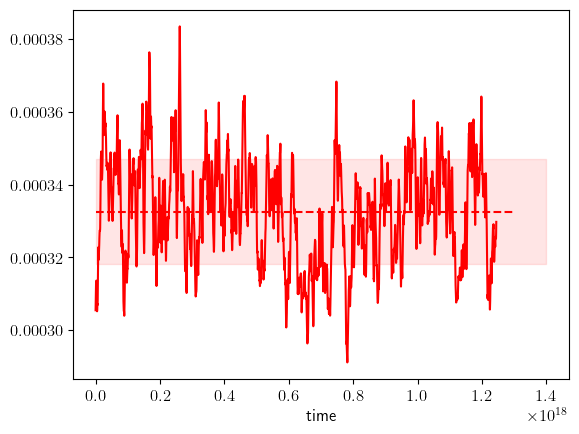

In [28]:
KE_time(case0_spectral_cnn).plot(label='40 years', color='red')
plt.hlines(KE_time(case0_spectral_cnn).mean(), 0, 13e17, color='red', linestyle='--', label='20 years mean')
plt.fill_between([0, 14e17], KE_time(case0_spectral_cnn).mean()-KE_time(case0_spectral_cnn).std(), KE_time(case0_spectral_cnn).mean()+KE_time(case0_spectral_cnn).std(), color='red', alpha=0.1)

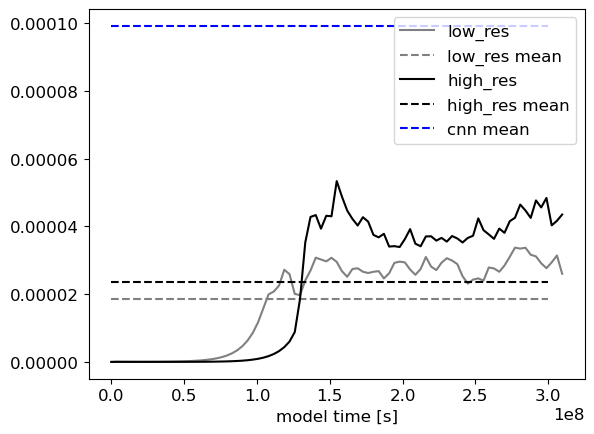

In [53]:
# KE_time(case4_cnn).plot(label='cnn')
KE_time(low_res.mean('run')).plot(label='low_res', color='gray')
plt.hlines( KE_time(low_res.mean('run')).mean('time'),0, 3e8, color='gray', linestyle='--', label='low_res mean')
KE_time(high_res.mean('run')).plot(label='high_res', color='black')
plt.hlines( KE_time(high_res.mean('run')).mean('time'),0, 3e8, color='black', linestyle='--', label='high_res mean')
plt.hlines(KE_time(case4_cnn).mean('time'),0, 3e8, color='blue', linestyle='--', label='cnn mean')
plt.legend()



In [68]:
import xarray as xr 
years10 = xr.open_dataset('/media/volume/sdc/qg/TransferLearning-QG/case4_cnn_test_with_from_fd_condition.nc')
years20 = xr.open_dataset('/media/volume/sdc/qg/TransferLearning-QG/case4_cnn_test_with_from_fd_condition_20years.nc')
years40 = xr.open_dataset('/media/volume/sdc/qg/TransferLearning-QG/case4_cnn_test_with_from_fd_condition_40years.nc')

Text(0.5, 1.0, 'TKE vs. Time')

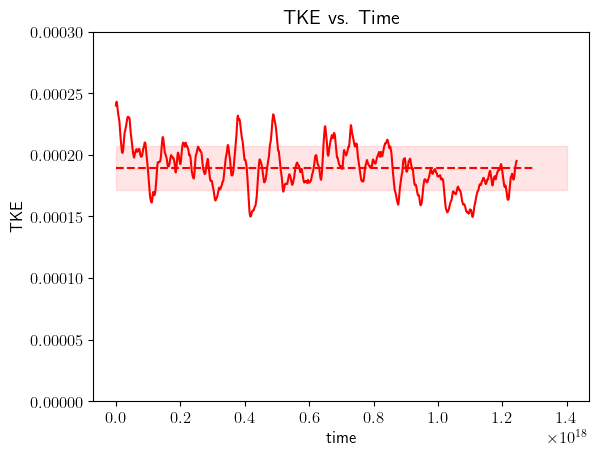

In [103]:
import matplotlib.pyplot as plt
# KE_time(years10).plot(label='10 years', color='blue')
# plt.hlines(KE_time(years10).mean(), 0, 6e17, color='blue', linestyle='--', label='10 years mean')
# plt.fill_between([0, 6e17], KE_time(years10).mean()-KE_time(years10).std(), KE_time(years10).mean()+KE_time(years10).std(), color='blue', alpha=0.1)

# KE_time(years20).plot(label='20 years', color='red')
# plt.hlines(KE_time(years20).mean(), 0, 6e17, color='red', linestyle='--', label='20 years mean')
# plt.fill_between([0, 6e17], KE_time(years20).mean()-KE_time(years20).std(), KE_time(years20).mean()+KE_time(years20).std(), color='red', alpha=0.1)

KE_time(years40).plot(label='20 years', color='red')
plt.hlines(KE_time(years40).mean(), 0, 13e17, color='red', linestyle='--', label='20 years mean')
plt.fill_between([0, 14e17], KE_time(years40).mean()-KE_time(years40).std(), KE_time(years40).mean()+KE_time(years40).std(), color='red', alpha=0.1)
plt.ylim(0, 3e-4)
plt.ylabel('TKE')
plt.title('TKE vs. Time')



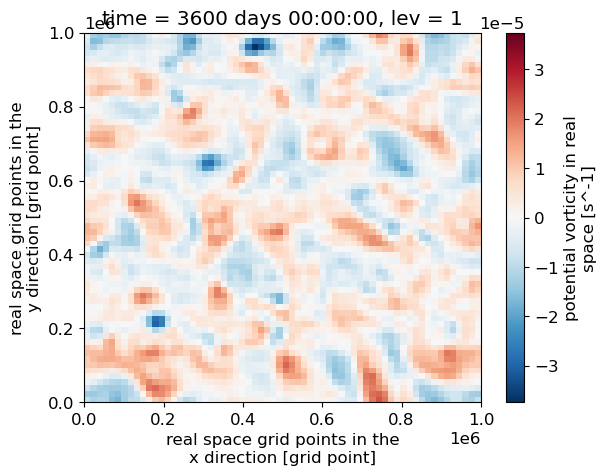

In [116]:
years10['q'].isel(time=time, lev=0).plot()

# Making Animation

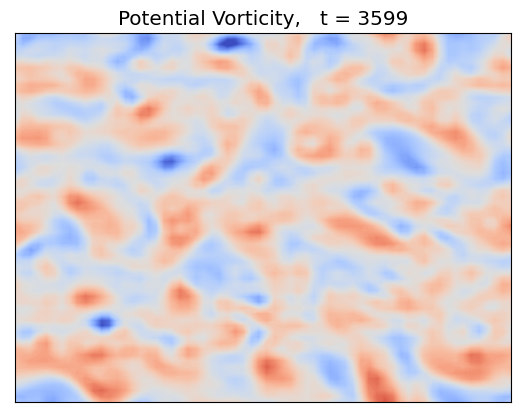

In [119]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Create a figure and axis
fig, ax = plt.subplots()

# Compute the global vmax and vmin across all snapshots
all_values = [years10['q'].isel(time=time, lev=0).values for time in range(3600)]
global_max = np.max(all_values)
global_min = np.min(all_values)
# vmax = global_max
# vmin = global_min
vmax = 3e-5
vmin = -vmax

# Define the update function
def update(time):
    ax.clear()
    Omega = years10['q'].isel(time=time, lev=0).values
    ax.contourf(Omega, cmap='coolwarm', vmin=vmin, vmax=vmax, levels=200)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(r'Potential Vorticity' + ',   t = ' + str(time))

# Create an animation
ani = animation.FuncAnimation(fig, update, frames=list(range(3400,3600)), repeat=True, interval=100, blit=False)


# Save as GIF
writer_gif = animation.PillowWriter(fps=20)
ani.save('animation.gif', writer=writer_gif)
plt.show()